In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import os
import plotly.express as px
from scipy.fft import fft, fftfreq
import statistics
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import *

from IPython.display import clear_output

import yaml
import json
import time
import joblib
import itertools

from wutils import *


In [2]:
df = pd.read_csv('/Users/nrprzybyl/ML/MAFAULDA/data/complex_mafaulda_new.csv')
df.head()

,axialUnderhang-Entropy,axialUnderhang-Kurtosis,axialUnderhang-Mean,axialUnderhang-F,axialUnderhang-2F,axialUnderhang-3F,axialOverhang-Entropy,axialOverhang-Kurtosis,axialOverhang-Mean,axialOverhang-F,...,microphone-Mean,microphone-F,microphone-2F,microphone-3F,tachometerSignal-Entropy,tachometerSignal-Kurtosis,tachometerSignal-Mean,fundamentalFrequency,class,path
0,11.700423,-0.028423,0.009096,0.209861,0.089478,0.081119,11.251919,0.144682,0.004352,0.020866,...,0.011994,0.028085,0.006391,0.022628,10.081655,1.920819,0.000409,60.6,vertical-misalignment,full/vertical-misalignment/1.78mm/62.0544.csv
1,11.691405,-0.315841,0.009299,0.171966,0.080338,0.063176,11.453312,0.634057,0.018882,0.015441,...,0.011745,0.025441,0.006911,0.024714,10.098573,2.051371,0.001856,59.2,vertical-misalignment,full/vertical-misalignment/1.78mm/60.6208.csv
2,11.691603,-0.314269,0.008901,0.167616,0.196603,0.045823,11.107915,0.434333,-0.011894,0.031162,...,0.011845,0.032116,0.021273,0.017417,10.207887,2.071535,-0.001486,58.6,vertical-misalignment,full/vertical-misalignment/1.78mm/60.0064.csv
3,11.715946,-0.040901,0.008365,0.172601,0.067104,0.116394,11.246643,0.829039,0.005535,0.022489,...,0.012393,0.027578,0.006499,0.020195,10.088735,2.064658,-0.001532,57.2,vertical-misalignment,full/vertical-misalignment/1.78mm/58.5728.csv
4,11.713568,-0.129168,0.008913,0.164138,0.064997,0.150388,11.184626,-0.092772,0.009297,0.017579,...,0.012543,0.025544,0.007792,0.023317,10.097232,2.038316,-0.000936,56.0,vertical-misalignment,full/vertical-misalignment/1.78mm/57.344.csv


In [3]:
# make our class dictionary
keys = list(np.unique(df['class']))
codes = [int(_) for _ in np.arange(0,len(keys))]
classDict = dict(zip(keys,codes))
classDict['mixed'] = 6
classDict

{'horizontal-misalignment': 0,
 'imbalance': 1,
 'normal': 2,
 'overhang': 3,
 'underhang': 4,
 'vertical-misalignment': 5,
 'mixed': 6}

In [4]:
df['CLASS'] = df['class']
df['class'] = df['class'].map(classDict)

In [5]:
X = df.drop(columns=['class','path','CLASS'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    shuffle=True, random_state=45,
                                                    stratify=None)

# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5,
#                                                  shuffle=True, random_state=45,
#                                                  stratify=None)
print(f'Length of train set: {len(X_train)}')
print(f'Length of test set: {len(X_test)}')
# print(f'Length of validation set: {len(X_val)}')

Length of train set: 1755
Length of test set: 196


In [6]:
# These indices tell us which files we will need to pull from to re-summarize subsamples of the data for
# our sliding window

idxs = X_test.index
idxs = [int(_) for _ in idxs]

## Here we are defining a Random Forest model and fitting it to our training set (80%). After the model is trained, we will get a baseline measurement of accuracy by utilizing our test set (10%). We will then use the indices of the validation set (10%) to tell us which data files we have not used up to this point. With this subset of data, we can re-summarize on smaller intervals of time (not the whole 5 seconds) and run those new data points through the model.

['./models/rfc1.joblib']

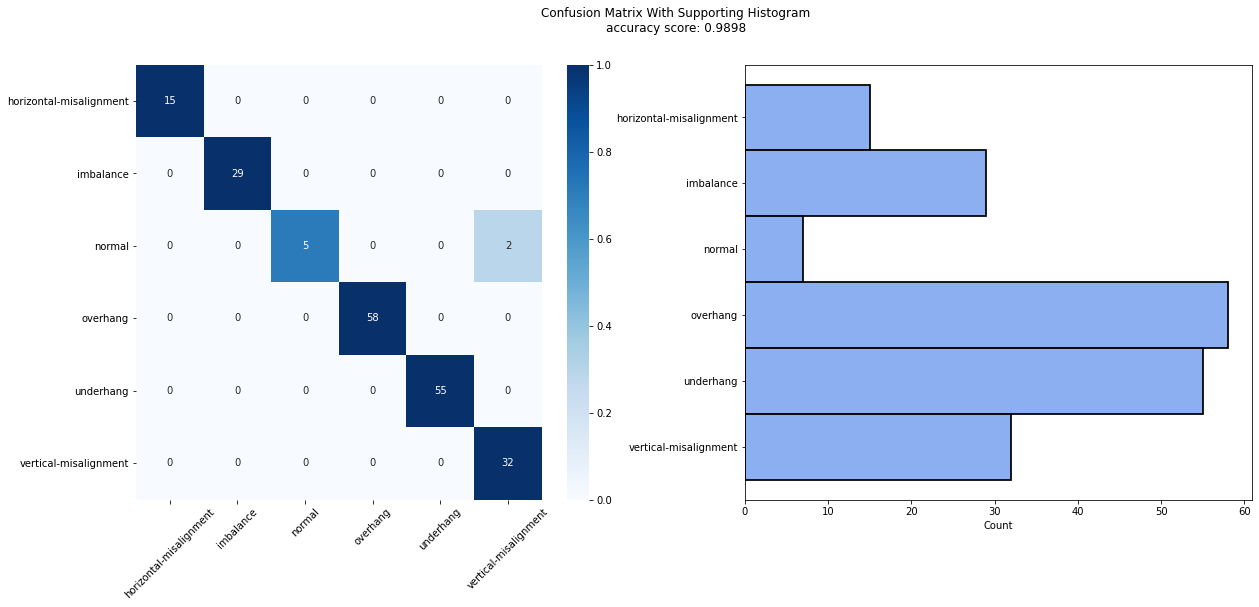

In [10]:
# used by the confusion_hist_plot function
target = 'class'

# define the model
model = RandomForestClassifier(bootstrap=True)
# fit the model with our training data
model.fit(X_train,y_train)
# try to predict the data points we set aside for testing
preds = model.predict(X_test)

#plot our results
confusion_hist_plot(df=df,y_test=y_test,preds=preds,codes=classDict)

#save our model
joblib.dump(model, "./models/rfc1.joblib")

In [10]:
# load the model
model = joblib.load('./models/rfc1.joblib')

In [8]:
val_files = df[['path','class','CLASS']].iloc[idxs]
val_files.head()
val_files.to_csv('./utils/test_files.csv')

In [13]:
S = ['tachometerSignal','axialUnderhang','radialUnderhang',
                  'tangentialUnderhang','axialOverhang','radialOverhang',
                  'tangentialOverhang','microphone']

import itertools
Stats = ['-Entropy','-Kurtosis','-Mean','-F','-2F', '-3F'] # '-Std'
Signals = ['axialUnderhang', 'axialOverhang','radialUnderhang',
          'radialOverhang','tangentialUnderhang','tangentialOverhang',
           'microphone']
Others = ['tachometerSignal-Entropy','tachometerSignal-Kurtosis','tachometerSignal-Mean',
          #'tachometerSignal-Std','tachometerSignal-Min','tachometerSignal-Max',
          'fundamentalFrequency','class']
columns = [*itertools.product(Signals,Stats)]
for i,col in enumerate(columns):
    columns[i] = col[0]+col[1]
columns = columns + Others

In [10]:
utils = {}
utils['signals'] = S
utils['columns'] = columns
utils['classes'] = classDict
utils['idxs'] = idxs
with open('./utils/utils1.json', 'w') as file:
    file.write(json.dumps(utils))

In [11]:
with open('./utils/utils1.json', 'r') as file:
    utils = json.load(file)

In [14]:
df = prepare_window_data(sensors=S, file_idxs=[1396,502,1944,1420])

In [11]:
trues, preds = slide_window(window_model=model, df=df, columns=columns, num_files=4, width_per_step=2500, window_width= 20000)
plot_window(df,trues=trues,preds=preds,class_dict=classDict, n=4, width_per_step=2500, window_width=20000)

In [9]:
val_files = pd.read_csv('./utils/test_files.csv').set_index('Unnamed: 0')

,path,class,CLASS
Unnamed: 0,,,
1420,full/normal/29.4912.csv,2,normal
1402,full/normal/47.7184.csv,2,normal
1481,full/overhang/ball_fault/0g/61.44.csv,3,overhang
355,full/underhang/ball_fault/0g/56.5248.csv,4,underhang
1579,full/overhang/outer_race/6g/57.5488.csv,3,overhang
...,...,...,...
300,full/vertical-misalignment/1.27mm/12.0832.csv,5,vertical-misalignment
1799,full/overhang/cage_fault/6g/26.2144.csv,3,overhang
1792,full/overhang/cage_fault/6g/32.3584.csv,3,overhang


In [21]:
with open('./config/config.yaml','r') as stream:
    try:
        conf = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
conf

{'default': {'plot_path': '/Users/nrprzybyl/ML/MAFAULDA/window/plots/',
  'experiment_name': 'test1'},
 'sweep': {'random_pick': True,
  'n_files': 10,
  'file_idxs': [1396, 502, 1418, 990, 1420, 1823, 1408, 1296, 1402, 144],
  'width_per_step': {'lo': 2500, 'hi': 7500, 'step': 500},
  'window_width': {'lo': 10000, 'hi': 100000, 'step': 10000}}}

In [23]:
names = ['all_underhangs','all_overhangs','all_imbalance','all_vertical_misalignments','all_horizontal_misalignments','all_normals']
classes = ['underhang','overhang','imbalance','vertical-misalignment','horizontal-misalignment','normal']
tag = '2500_250k'
for i,n in enumerate(names):
    conf['default']['experiment_name'] = f'{n}_{tag}'
    conf['default']['plot_path'] = '/ac-project/nprzybylski/window/plots/'
    conf['sweep']['random_pick'] = False
    conf['sweep']['file_idxs'] = [*val_files[val_files['CLASS'] == classes[i]].index]
    conf['sweep']['width_per_step']['lo'] = 2500
    conf['sweep']['width_per_step']['hi'] = 2500
    conf['sweep']['window_width']['lo'] = 5000
    conf['sweep']['window_width']['hi'] = 250000
    conf['sweep']['window_width']['step'] = 5000
    
    with open(f'./config/{n}_{tag}.yaml', 'w') as f:
        yaml.dump(conf, f)

In [86]:
with open(f"./config/{conf['default']['experiment_name']}.yaml", 'w') as file:
    yaml.dump(conf,file)

In [ ]:
t = {}
t['zones'] = [ {} for _ in np.ones(4) ]
for i in range(4):
    
    t['zones'][i]['acc'] = 1
t

In [18]:
with open('plots/all_normals/out','r') as file:
    t = json.load(file)

In [19]:
dirs = ['all_normals','all_overhangs','all_vertical_misalignments','all_horizontal_misalignments','all_imbalance','all_underhangs']
labels = ['normal','overhang','vertical-misalignment','horizontal-misalignment','imbalance','underhang']
accs = []
for d in dirs:
    with open(f'plots/{d}_250000/out','r') as file:
        t = json.load(file)
        accs.append([t[_]['acc'] for _ in t])
accs = np.array(accs)

In [16]:
for i,a in enumerate(accs):
    print(f'average {labels[i]} accuracy across all windows: {round(a[0],4)}')

average normal accuracy across all windows: 0.34
average overhang accuracy across all windows: 0.96
average vertical-misalignment accuracy across all windows: 0.9729
average horizontal-misalignment accuracy across all windows: 0.7486
average imbalance accuracy across all windows: 0.7971
average underhang accuracy across all windows: 0.9104


In [17]:
model.predict(X_test.loc[val_files[val_files['CLASS'] == 'normal'].index])

array([2, 2, 2, 5, 5, 2, 2])

In [45]:
all_accs = []
for i,_ in enumerate(accs):
    all_accs.append([*accs1[i]]+_)

In [68]:
means = []
for i in range(len(n[0])):
    means.append(np.mean(n[:,i]))

In [60]:
n = np.array(all_accs)

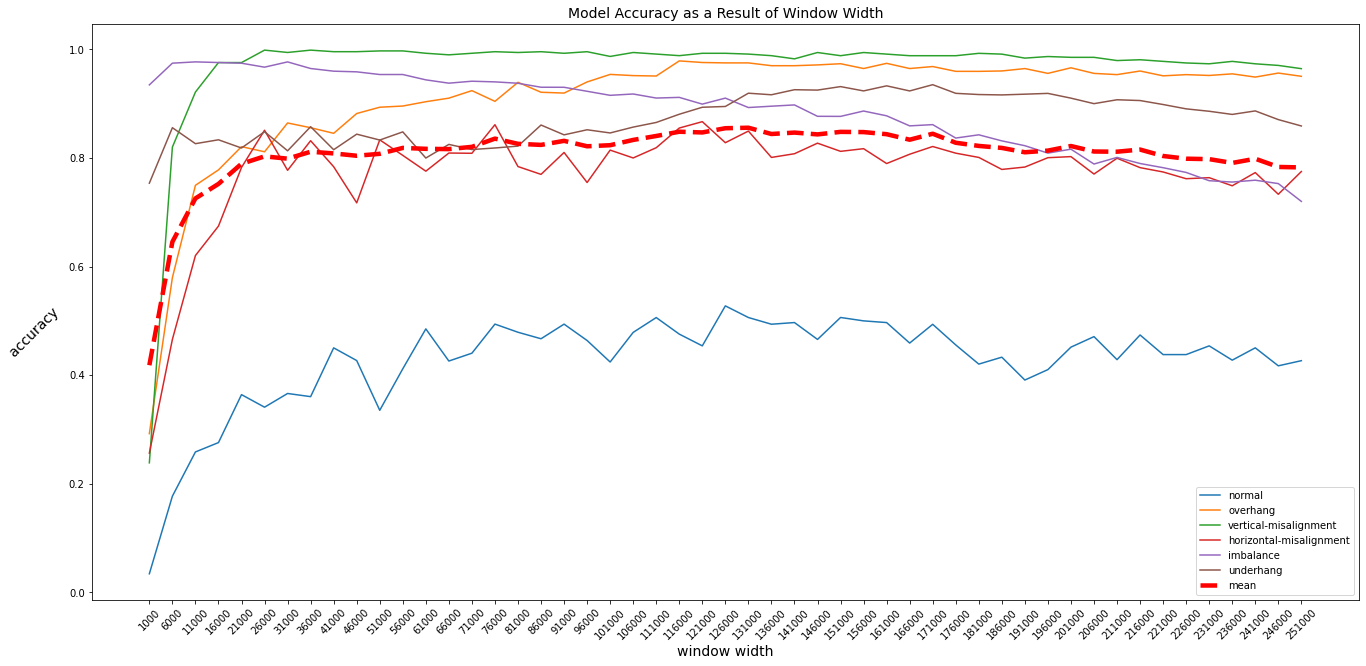

In [78]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
for i,a in enumerate(all_accs):
    ax.plot(a,label=labels[i])
plt.plot(means,label='mean',linewidth=4.5,linestyle='dashed',color='r')
plt.legend()
l=np.arange(1000,256000,5000)
ax.set_xticks(np.arange(len(l)))
ax.set_xticklabels(l,rotation=45)
plt.xlabel('window width',fontdict={'size':14})
plt.ylabel('accuracy                ',rotation=45,fontdict={'size':14})
plt.title('Model Accuracy as a Result of Window Width',fontdict={'size':14});

## Data to save after each run

        - accuracy
            - overall (maybe)
            - minus "mixed" areas (current)
            - per zone
            - per class (maybe save confusion matrix for this part)
            
        - metadata (by zone)
            - source file path
                - class
                - weight/misalignment/rpm/type of fault(ball, outer race, cage)

## Example output

In [464]:
from pprint import pprint
test1 = {   
    '1000_10000': {
        'overall_acc': 30,
        'acc': 35,
        'zones': {
            '1': { 'acc': 40, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 30, 'path': 'full/normal/12.288.csv' }
        }
    },
    '2000_10000': {
        'overall_acc': 40,
        'acc': 45,
        'zones': {
            '1': { 'acc': 50, 'path': 'full/overhang/ball_fault/6g/12.6976.csv' },
            '2': { 'acc': 40, 'path': 'full/normal/12.288.csv' }
        }
    }
}
pprint(test1)

{'1000_10000': {'acc': 35,
                'overall_acc': 30,
                'zones': {'1': {'acc': 40,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 30, 'path': 'full/normal/12.288.csv'}}},
 '2000_10000': {'acc': 45,
                'overall_acc': 40,
                'zones': {'1': {'acc': 50,
                                'path': 'full/overhang/ball_fault/6g/12.6976.csv'},
                          '2': {'acc': 40, 'path': 'full/normal/12.288.csv'}}}}
